## Detecting Different Handsigns

<p>This project utilizes google protocol buffer for real-time detection of handsigns presented infront of a camera.</p>

In [12]:
from ctypes import util
import tensorflow as tf
import object_detection
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from object_detection.builders import model_builder
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util
from google.protobuf import text_format
import cv2
import uuid
import os
import time
import wget
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:

labels = ['thumbsup', 'thumbsdown', 'thankyou', 'livelong']
numberof_imgs = 5

IMAGES_PATH = 'Tensorflow/workspace/images/collectedimages'

if not os.path.exists(IMAGES_PATH):
  if os.name == 'nt':
    os.makedirs(IMAGES_PATH)
for label in labels:
  path = os.path.join(IMAGES_PATH, label)
  if not os.path.exists(path):
    os.makedirs(path)

'''
for label in labels:
    cap = cv2.VideoCapture(0)
    print('Collecting images for {}'.format(label))
    time.sleep(5)
    for imgnum in range(numberof_imgs):
      print('Collecting image {}'.format(imgnum))
      ret, frame = cap.read()
      imgname = os.path.join(IMAGES_PATH,label,label+'.'+'{}.jpg'.format(str(uuid.uuid1())))
      cv2.imwrite(imgname, frame)
      cv2.imshow('frame', frame)
      time.sleep(2)

      if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
'''
LABELIMG_PATH = os.path.join('Tensorflow/labelimg')

if not os.path.exists(LABELIMG_PATH):
  os.makedirs(LABELIMG_PATH)

# Open Labelimg for labeling imgs (run this on jupyter)
!cd C:\Users\danie\Vscodepjcts\TF\Tensorflow\labelimg\labelImg && python labelImg.py

# Configure training library
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'nt':
          os.makedirs(path)

In [14]:
# Clone tensorflow objdetectionlib
'''
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}
'''

"\nif not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):\n    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}\n"

In [15]:
# Object_detection lib download
'''
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 
'''

'\nif os.name==\'nt\':\n    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"\n    wget.download(url)\n    !move protoc-3.15.6-win64.zip {paths[\'PROTOC_PATH\']}\n    !cd {paths[\'PROTOC_PATH\']} && tar -xf protoc-3.15.6-win64.zip\n    os.environ[\'PATH\'] += os.pathsep + os.path.abspath(os.path.join(paths[\'PROTOC_PATH\'], \'bin\'))   \n    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install\n    !cd Tensorflow/models/research/slim && pip install -e . \n'

In [16]:
# Verify Installation
'''
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}
'''

"\nVERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')\n!python {VERIFICATION_SCRIPT}\n"

In [17]:
# Copy and paste TF model from model zoo into pre-trained model path
'''
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
'''

"\nif os.name == 'nt':\n    wget.download(PRETRAINED_MODEL_URL)\n    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}\n    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}\n"

In [18]:
# Create Label Map
'''
labels = [{'name':'ThumbsUp', 'id':1}, {'name':'ThumbsDown', 'id':2}, {'name':'ThankYou', 'id':3}, {'name':'LiveLong', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')
'''

"\nlabels = [{'name':'ThumbsUp', 'id':1}, {'name':'ThumbsDown', 'id':2}, {'name':'ThankYou', 'id':3}, {'name':'LiveLong', 'id':4}]\n\nwith open(files['LABELMAP'], 'w') as f:\n    for label in labels:\n        f.write('item { \n')\n        f.write('\tname:'{}'\n'.format(label['name']))\n        f.write('\tid:{}\n'.format(label['id']))\n        f.write('}\n')\n"

In [19]:
# Create TF records
'''
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}
'''

"\nif not os.path.exists(files['TF_RECORD_SCRIPT']):\n    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}\n"

In [20]:
# Test & Train records
''' 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 
'''

" \n!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} \n!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} \n"

In [21]:
# Copy pipeline file into custom model name folder
'''
if os.name == 'nt':
  !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
'''

"\nif os.name == 'nt':\n  !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}\n"

In [22]:
# Update config for transfer learning
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

#config

In [23]:
# Train the model
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000


In [24]:
# Evaluate the model
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [25]:
# Load train model from checkpoint
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [26]:
# Detect from image
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
# IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'livelong.02533422-940e-11eb-9dbd-5cf3709bbcc6.jpg')
# img = cv2.imread(IMAGE_PATH)
# image_np = np.array(img)

# input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
# detections = detect_fn(input_tensor)

# num_detections = int(detections.pop('num_detections'))
# detections = {key: value[0, :num_detections].numpy()
#               for key, value in detections.items()}
# detections['num_detections'] = num_detections

# # detection_classes should be ints.
# detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# label_id_offset = 1
# image_np_with_detections = image_np.copy()

# viz_utils.visualize_boxes_and_labels_on_image_array(
#             image_np_with_detections,
#             detections['detection_boxes'],
#             detections['detection_classes']+label_id_offset,
#             detections['detection_scores'],
#             category_index,
#             use_normalized_coordinates=True,
#             max_boxes_to_draw=5,
#             min_score_thresh=.8,
#             agnostic_mode=False)

# plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
# plt.show()

In [27]:
# Realtime Detection

cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

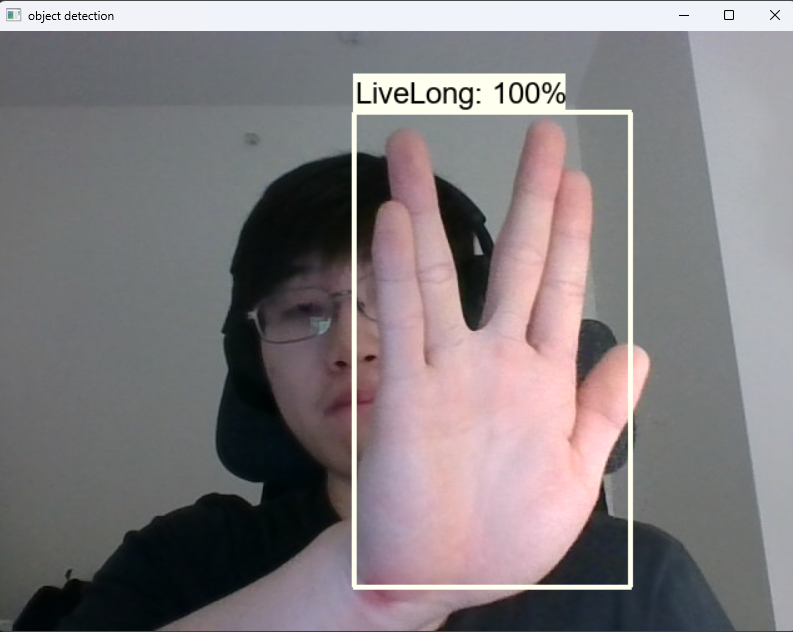